In [25]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from pathlib import Path
import urllib.request
import zipfile
from tqdm.auto import tqdm


/Users/carki/Desktop/Dev/codeit/codeit/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

BASE_DIR = Path().resolve().parent.parent.parent  # 현재 작업 디렉토리 기준
DATA_DIR = BASE_DIR / 'common' / 'data'

print("데이터 경로:", DATA_DIR)

데이터 경로: /Users/carki/Desktop/Dev/codeit/common/data


In [8]:


# 데이터 디렉토리 생성
DATA_DIR.mkdir(parents=True, exist_ok=True)

# 다운로드
url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
zip_path = DATA_DIR / "PennFudanPed.zip"

urllib.request.urlretrieve(url, zip_path)

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

print("압축 해제 완료:", DATA_DIR)

압축 해제 완료: /Users/carki/Desktop/Dev/codeit/common/data


# 1. 데이터셋 정의 (PennFudanDataset)

In [17]:
# PennFudan 데이터셋은 보행자 이미지와 각 이미지에 대한 마스크(분할 정보)를 포함합니다.
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        """
        root: 데이터셋의 루트 폴더 (예: './PennFudanPed')
        transforms: 이미지와 타겟에 적용할 변환 함수
        """
        self.root = root
        self.transforms = transforms
        # PNGImages 폴더와 PedMasks 폴더 내의 파일 이름을 정렬해서 리스트로 저장
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx):
        # idx번째 이미지와 마스크의 파일 경로 생성
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # read_image: 이미지를 Tensor 형식으로 읽어옵니다.
        img = read_image(img_path)
        mask = read_image(mask_path)

        # mask 텐서의 유니크한 값(색상 또는 인스턴스 번호)을 추출합니다.
        # 첫 번째 값은 배경이므로 제거합니다.
        obj_ids = torch.unique(mask)[1:]

        # 각 객체 인스턴스에 대해 binary mask를 생성합니다.
        # mask == obj_ids[:, None, None]는 각 인스턴스마다 True/False 마스크를 만듭니다.
        # .to(dtype=torch.uint8)로 자료형을 8비트 정수형으로 변환합니다.
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # masks_to_boxes: 각 binary mask에서 바운딩 박스([x_min, y_min, x_max, y_max]) 계산
        boxes = masks_to_boxes(masks)

        # PennFudan 데이터셋은 보행자만 있으므로, 모든 객체에 1번 라벨을 부여합니다.
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)

        # 이미지 id는 단순히 idx 값을 사용 (평가 시 사용)
        image_id = idx

        # 각 바운딩 박스의 면적 계산: (x_max - x_min) * (y_max - y_min)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # 모든 객체는 군집(crowd)이 아니라고 가정하여 0으로 설정합니다.
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

        # tv_tensors를 사용하여 이미지와 타겟을 래핑합니다.
        # 이는 torchvision의 최신 변환 및 시각화 기능을 사용하기 위함입니다.
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # 만약 변환(transforms)이 있다면 적용 (예: 데이터 증강)
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        # 데이터셋의 전체 이미지 수 반환
        return len(self.imgs)

# 2. 데이터 변환 함수 정의

In [15]:
def get_transform(train):
    """
    train: True이면 학습용 변환을, False이면 검증용 변환을 적용합니다.
    """
    transforms = []
    if train:
        # 학습 시 좌우 반전(data augmentation)을 50% 확률로 적용
        transforms.append(T.RandomHorizontalFlip(0.5))
    # 이미지를 float형으로 변환하고 0~1 범위로 스케일 조정
    transforms.append(T.ToDtype(torch.float, scale=True))
    # Tensor로 변환 (이미 ToDtype에서 텐서가 유지되지만, 혹시 모를 변환을 위해 추가)
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# 3. 모델 정의 (COCO 사전 학습된 Mask R-CNN 사용)

In [10]:
# COCO에서 사전 학습된 Mask R-CNN (ResNet50 FPN 기반) 모델을 사용하여 파인튜닝합니다.
# 이 모델은 객체 검출 및 인스턴스 분할을 모두 수행합니다.
num_classes = 2  # 1 class (person) + background
device = "cuda" if torch.cuda.is_available() else "cpu"

# torchvision에서 COCO 데이터셋으로 사전 학습된 Mask R-CNN 모델 불러오기
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

# -------------------------
# 박스 예측기 (classification head) 교체
# -------------------------
# 모델의 마지막 계층인 box_predictor의 입력 피처 수를 확인합니다.
in_features = model.roi_heads.box_predictor.cls_score.in_features
# FastRCNNPredictor를 사용하여 새롭게 분류기(head)를 생성합니다.
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# -------------------------
# 마스크 예측기 (mask head) 교체
# -------------------------
# mask_predictor의 conv5_mask 레이어의 입력 채널 수 확인
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256  # 마스크 예측기에서 사용할 숨겨진 레이어의 크기
# MaskRCNNPredictor를 사용하여 마스크 분류기(head)를 새롭게 생성합니다.
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# 모델을 선택한 디바이스(CPU 또는 GPU)로 이동
model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/carki/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:15<00:00, 11.4MB/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# 4. DataLoader 및 collate_fn 정의

In [24]:
def collate_fn(batch):
    """
    DataLoader에서 배치를 생성할 때, 각 이미지와 타겟을 하나의 튜플로 묶어줍니다.
    """
    return tuple(zip(*batch))

PENNFUDAN_DIR = f'{DATA_DIR}/PennFudanPed'
print(PENNFUDAN_DIR)

# 데이터셋 준비: PennFudan 데이터셋의 경로와 변환 함수 지정 
dataset = PennFudanDataset(PENNFUDAN_DIR, get_transform(train=True))
dataset_test = PennFudanDataset(PENNFUDAN_DIR, get_transform(train=False))

# 데이터셋을 학습용과 테스트용으로 나눕니다.
# 여기서는 무작위로 선택하여 마지막 50개 이미지를 테스트셋으로 사용합니다.
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# DataLoader 생성: 배치 크기, 셔플 여부, 그리고 collate_fn 지정
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)


/Users/carki/Desktop/Dev/codeit/common/data/PennFudanPed
<class 'pathlib._local.PosixPath'>


# 5. 간단한 학습 루프 (2 에폭 예시)

In [27]:
# 학습 가능한 파라미터만 모아 옵티마이저에 전달
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# 학습률 스케줄러: 3 에폭마다 학습률을 0.1배 감소
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 2  # 학습 에폭 수
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 전환 (Dropout, BatchNorm 등이 학습 모드로 작동)
    epoch_loss = 0  # 에폭별 손실 누적 변수
    for images, targets in tqdm(data_loader, desc=f'{epoch + 1}/{num_epochs}'):
        # 각 이미지와 타겟을 device(GPU 또는 CPU)로 이동
        images = [img.to(device) for img in images]
        # 타겟은 dict 형식이며, tensor인 항목만 to(device) 처리
        targets = [{k: (v.to(device) if torch.is_tensor(v) else v) for k, v in t.items()} for t in targets]

        # 모델에 이미지와 타겟을 전달하면, 학습 모드에서는 손실(loss) dict를 반환합니다.
        loss_dict = model(images, targets)
        # dict의 모든 손실값을 합산하여 총 손실을 계산합니다.
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()  # 손실 값을 float로 누적

        optimizer.zero_grad()  # 이전 배치의 기울기(gradient) 초기화
        losses.backward()      # 역전파를 통해 기울기 계산
        optimizer.step()       # 옵티마이저가 파라미터를 업데이트

    lr_scheduler.step()  # 에폭마다 학습률 업데이트
    print(f"Loss: {epoch_loss:.4f}")

print("학습 완료!")

1/2: 100%|██████████| 60/60 [06:36<00:00,  6.61s/it]


Loss: 38.7101


2/2: 100%|██████████| 60/60 [06:40<00:00,  6.67s/it]

Loss: 18.3347
학습 완료!


# 6. 평가 및 결과 시각화 (한 이미지 예시)

In [41]:
model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등이 평가 모드로 작동)
# 예측할 이미지 파일 경로 지정
image = read_image(f"{PENNFUDAN_DIR}/PNGImages/FudanPed00046.png")
# 평가용 변환 함수 적용 (학습용 변환이 아닌 검증용 변환 사용)
eval_transform = get_transform(train=False)
with torch.no_grad():
    # eval_transform을 적용하면 이미지 텐서의 shape이 유지됩니다.
    # 여기서 [:3, ...]는 이미지의 처음 3채널(RGB)만 선택합니다.
    x = eval_transform(image)[:3, ...].to(device)
    # 모델에 단일 이미지의 배치를 전달 (배치 크기는 1)
    predictions = model([x])
    pred = predictions[0]
    
print(image.shape)

torch.Size([3, 438, 567])


In [ ]:
# 다른 이미지 테스트용
# IMAGE_TEST_DIR = f'{DATA_DIR}/self_test'
# image = read_image(f"{IMAGE_TEST_DIR}/IMG_1399.JPG")

# eval_transform = get_transform(train=False)
# with torch.no_grad():
#     # eval_transform을 적용하면 이미지 텐서의 shape이 유지됩니다.
#     # 여기서 [:3, ...]는 이미지의 처음 3채널(RGB)만 선택합니다.
#     x = eval_transform(image)[:3, ...].to(device)
#     # 모델에 단일 이미지의 배치를 전달 (배치 크기는 1)
#     predictions = model([x])
#     pred = predictions[0]

# 시각화를 위한 전처리
이미지의 픽셀 값을 0~255 범위로 정규화하여 uint8 타입으로 변환합니다.

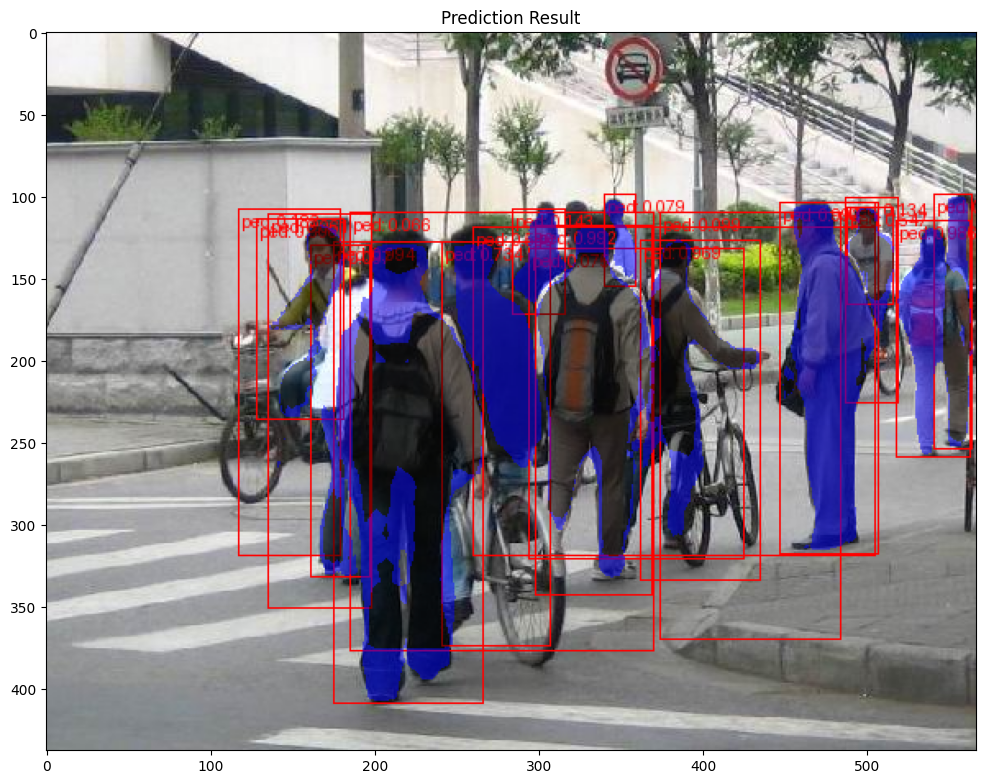

In [42]:
# image.min(), image.max()를 이용해 정규화하고 [:3, ...]로 RGB 채널만 선택합니다.
image_vis = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)[:3, ...]
# 예측된 각 박스에 대해, 점수를 포함한 라벨 문자열을 생성합니다.
pred_labels = [f"ped: {score:.3f}" for score in pred["scores"]]
# 예측된 바운딩 박스 좌표를 정수형(long)으로 변환합니다.
pred_boxes = pred["boxes"].long()
# draw_bounding_boxes: 이미지 위에 박스를 그림. output_image는 Tensor 형태로 반환됩니다.
output_image = torchvision.utils.draw_bounding_boxes(image_vis, pred_boxes, pred_labels, colors="red")


# 마스크 예측 결과: 0.7 이상의 확률을 가진 픽셀을 True로 설정합니다.
# squeeze(1)은 마스크 텐서의 차원을 줄여줍니다.
masks = (pred["masks"] > 0.7).squeeze(1)
# draw_segmentation_masks: 이미지 위에 반투명한 색상의 마스크를 그림.
output_image = torchvision.utils.draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


# 결과 시각화: plt.imshow()에 전달하기 전에 채널 순서를 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경합니다.
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.title("Prediction Result")
plt.show()